<a href="https://colab.research.google.com/github/DermaScan-Bangkit-2024-CapstoneProject/DermaScan-Machine-Learning/blob/main/EDA_Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

#Step 1: Load Dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to the train and test directories
train_dir = '/content/drive/MyDrive/datasets/skindiseasedataset/SkinDisease/train'
test_dir = '/content/drive/MyDrive/datasets/skindiseasedataset/SkinDisease/test'

# Initialize ImageDataGenerator for train and test sets
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=40,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Random shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill pixels after transformation
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for the test set

# Set up the train and test data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to the target size (adjust as needed)
    batch_size=32,  # Number of images to return in each batch
    class_mode='binary',  # Use 'binary' for binary classification (e.g., healthy vs. diseased)
    shuffle=True  # Shuffle the data to avoid bias in training
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  # Resize images to the target size (adjust as needed)
    batch_size=32,  # Number of images to return in each batch
    class_mode='binary',  # Use 'binary' for binary classification (use 'categorical' for multi-class)
    shuffle=False  # Don't shuffle the test set
)

# Example: To see a batch of images and their labels
x_batch, y_batch = next(train_generator)
print(x_batch.shape)  # Shape of the batch (batch_size, height, width, channels)
print(y_batch)  # Corresponding labels (0 or 1 for binary classification)

Found 13898 images belonging to 22 classes.
Found 1546 images belonging to 22 classes.
(32, 150, 150, 3)
[20.  9. 11. 14. 20. 16. 12. 12.  7. 21.  8. 16. 10.  3. 14.  2. 17. 13.
 19. 10.  2. 14. 10.  2.  2. 17.  1. 16. 16. 17. 12.  7.]


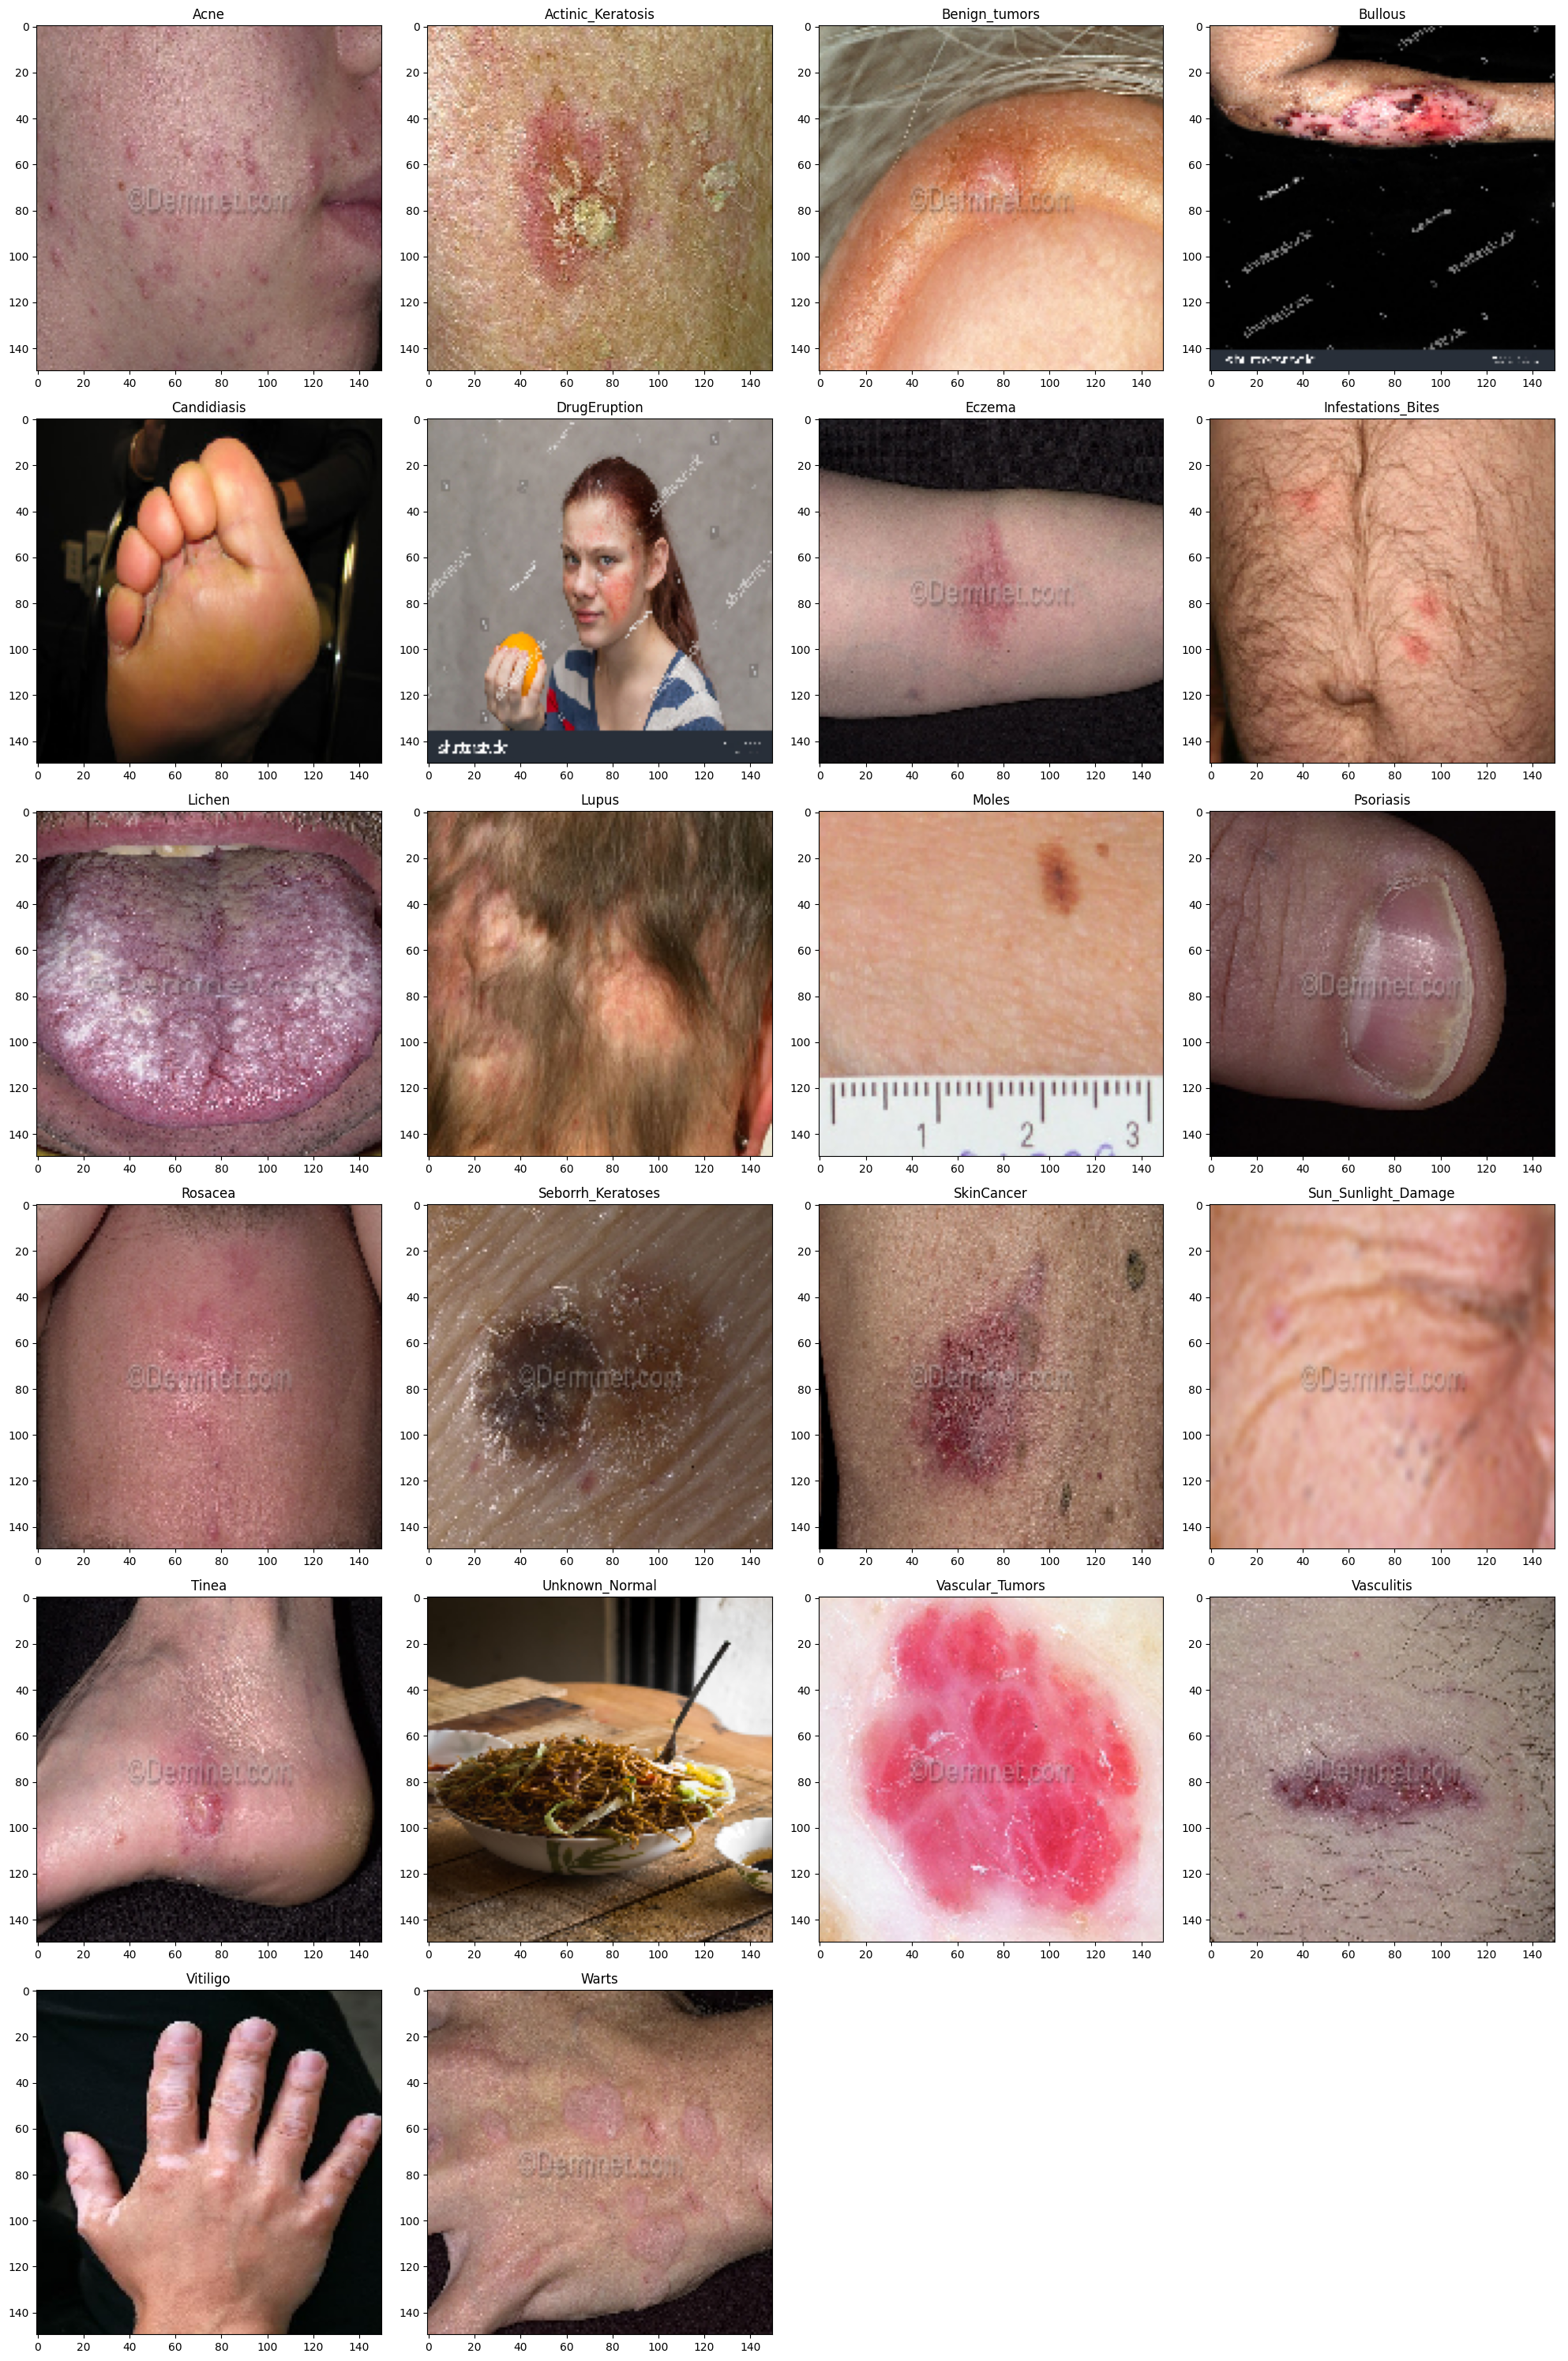

In [25]:
# Path to the train directory
train_dir = '/content/drive/MyDrive/datasets/skindiseasedataset/SkinDisease/train'

# List all subdirectories (disease classes) in the train directory
disease_classes = os.listdir(train_dir)

# Set the number of images to display per class (1 image per class)
images_per_class = 1  # We will show 1 image per class
total_images = 22  # We will display a total of 22 images (one per class)

# Calculate grid dimensions based on total_images
ncols = 4  # Number of columns in the grid
nrows = (total_images // ncols) + (1 if total_images % ncols else 0)  # Adjust rows to fit the number of images

# Create a grid to display the images
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
ax = ax.ravel()  # Flatten the axis array to make it easier to index

# Keep track of the index for placing images on the grid
idx = 0

# Loop through the first 22 disease classes
for disease_class in disease_classes[:22]:  # Limit to the first 22 classes
    disease_class_path = os.path.join(train_dir, disease_class)

    # List the image files in the disease class directory
    image_files = os.listdir(disease_class_path)

    # Get the first image file (since we only want 1 image per class)
    sample_image = image_files[0]

    # Get the full path of the image file
    img_path = os.path.join(disease_class_path, sample_image)

    # Load the image (Resize to smaller size, e.g., 100x100)
    img = image.load_img(img_path, target_size=(150, 150))  # Resize to smaller size (100x100)

    # Convert image to array for visualization
    img_array = image.img_to_array(img) / 255.0  # Normalize the image (same as ImageDataGenerator)

    # Plot the image on the grid
    ax[idx].imshow(img_array)
    ax[idx].title.set_text(f"{disease_class}")  # Display class name as the title

    # Show both axes (x and y)
    ax[idx].axis('on')  # Enable both axes

    idx += 1

    if idx >= total_images:  # Stop once we've displayed 22 images
        break

# Hide any unused axes (the remaining empty subplots)
for j in range(idx, len(ax)):
    ax[j].axis('off')  # Turn off the unused subplots

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#Step 4: Loading and Resizing of Images

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_resize_images(directory, target_size=(150, 150)):
    """
    This function loads and resizes images from a directory.
    """
    images = []
    labels = []
    class_labels = os.listdir(directory)  # List all disease classes

    for label in class_labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):  # Ensure it is a directory
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                try:
                    img = load_img(img_path, target_size=target_size)  # Resize image
                    img_array = img_to_array(img) / 255.0  # Convert to array and normalize
                    images.append(img_array)
                    labels.append(label)  # Use the directory name as label
                except:
                    print(f"Failed to process image: {img_path}")
                    continue  # Skip if image cannot be processed

    return np.array(images), labels

# Load and resize images from the train and test directories
train_images, train_labels = load_and_resize_images(train_dir)
test_images, test_labels = load_and_resize_images(test_dir)

print(f"Loaded {train_images.shape[0]} training images.")
print(f"Loaded {test_images.shape[0]} test images.")

Loaded 13898 training images.
Loaded 1546 test images.


#Step 5: Train-Test Split

In [28]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f"Training data: {X_train.shape[0]} images")
print(f"Test data: {X_test.shape[0]} images")

Training data: 11117 images
Test data: 2780 images
